In [181]:
from neo4j import GraphDatabase
import pandas as pd
import warnings
from neo4j import GraphDatabase
from dotenv import load_dotenv
load_dotenv()
import xgboost as xgb
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from collections import Counter
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
# NumPy関連のRuntimeWarningを無効化
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [62]:
# DB接続処理
# Neo4jに接続
uri = "bolt://localhost:7687"
user = "neo4j"
password = "abcd7890"

# ドライバを作成
driver = GraphDatabase.driver(uri, auth=(user, password))

In [63]:
def get_food_subtype_relationships(tx):
    query4 = """
        CALL {
            MATCH (f:Food)
            RETURN COLLECT(f) AS foods
        }

        WITH foods
        UNWIND foods AS f1
        UNWIND foods AS f2
        WITH f1, f2
        WHERE id(f1) < id(f2)

        OPTIONAL MATCH (f1)-[r:USED_TOGETHER]->(f2)
        OPTIONAL MATCH (f1)-[:SCENTED]->(a:Aroma)<-[:SCENTED]-(f2)

        RETURN f1.id AS food1_id, 
            f2.id AS food2_id, 
            COALESCE(r.frequency, 0) AS frequency,
            COUNT(a) AS shared_aromas,
            f1.popularity AS food1_popularity,
            f2.popularity AS food2_popularity,
            f1.aroma_page_rank AS food1_aroma_page_rank, 
            f2.aroma_page_rank AS food2_aroma_page_rank,
            f1.recipe_page_rank AS food1_recipe_page_rank, 
            f2.recipe_page_rank AS food2_recipe_page_rank,
            gds.similarity.cosine(f1.word_vector, f2.word_vector) as word_similarity, 
            gds.similarity.overlap(f1.flavor_vector, f2.flavor_vector) as flavor_similarity
        ORDER BY frequency DESC, shared_aromas DESC
    """
    return list(tx.run(query4))

with driver.session() as session:
    data = session.read_transaction(get_food_subtype_relationships)

/var/folders/g4/fbyxhbrx6h3_4s4m15x3bly00000gn/T/ipykernel_52833/4021023388.py:34: DeprecationWarning: read_transaction has been renamed to execute_read
  data = session.read_transaction(get_food_subtype_relationships)
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL () { ... }} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL {\n            MATCH (f:Food)\n            RETURN COLLECT(f) AS foods\n        }\n\n        WITH foods\n        UNWIND foods AS f1\n        UNWIND foods AS f2\n        WITH f1, f2\n        WHERE id(f1) < id(f2)\n\n        OPTIONAL MATCH (f1)-[r:USED_TOGETHER]->(f2)\n        OPTIONAL MATCH (f1)-[:SCENTED]->(a:Aroma)<-[:SCENTED]-(f2)\n\n        RETURN f1.id AS food1_id, \n            

In [64]:
target_column = [ "frequency","shared_aromas", "food1_popularity", "food2_popularity", "food1_aroma_page_rank","food2_aroma_page_rank", "food1_recipe_page_rank", "food2_recipe_page_rank", "word_similarity", "flavor_similarity"]

In [65]:
df = pd.DataFrame(data, columns=["food1_id", "food2_id", *target_column])
df.fillna(0, inplace=True)
df

,food1_id,food2_id,frequency,shared_aromas,food1_popularity,food2_popularity,food1_aroma_page_rank,food2_aroma_page_rank,food1_recipe_page_rank,food2_recipe_page_rank,word_similarity,flavor_similarity
0,garlic,garden_tomato,473,10,94,45,0.470999,0.663428,34.20299,13.690042,-0.015735,0.002265
1,garlic,pasta,473,10,94,36,0.470999,0.730687,34.20299,6.179398,0.376691,0.002265
2,garlic,biscuit,473,10,94,5,0.470999,1.116541,34.20299,0.775157,-0.091925,0.001133
3,garlic,blue_mussel,473,10,94,1,0.470999,0.501666,34.20299,0.306566,-0.075320,0.002265
4,garlic,pink_salmon,473,10,94,11,0.470999,0.501666,34.20299,1.876797,-0.029451,0.002265
...,...,...,...,...,...,...,...,...,...,...,...,...
495351,cape_gooseberry,mallard_duck,0,0,0,0,0.150000,0.150000,0.15000,0.150000,0.853496,0.001133
495352,cape_gooseberry,greylag_goose,0,0,0,0,0.150000,0.150000,0.15000,0.150000,0.858939,0.001133
495353,mule_deer,mallard_duck,0,0,0,0,0.150000,0.150000,0.15000,0.150000,0.868395,0.001133
495354,mule_deer,greylag_goose,0,0,0,0,0.150000,0.150000,0.15000,0.150000,0.853026,0.001133


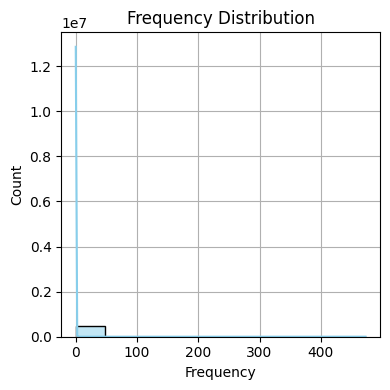

In [66]:
# frequency の分布の確認（ヒストグラム）
plt.figure(figsize=(4, 4))
sns.histplot(df["frequency"], bins=10, kde=True, color="skyblue")
plt.title("Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
corr_matrix = df[target_column].corr()
corr_matrix

,frequency,shared_aromas,food1_popularity,food2_popularity,food1_aroma_page_rank,food2_aroma_page_rank,food1_recipe_page_rank,food2_recipe_page_rank,word_similarity,flavor_similarity
frequency,1.000000,0.025600,0.215197,0.082052,0.025499,0.017726,0.242208,0.077304,-0.033400,0.009647
shared_aromas,0.025600,1.000000,0.107171,0.055000,0.274103,0.627632,0.082838,0.043705,-0.093005,0.366969
food1_popularity,0.215197,0.107171,1.000000,-0.000517,0.254150,0.021699,0.956471,-0.000603,-0.259369,0.027812
food2_popularity,0.082052,0.055000,-0.000517,1.000000,-0.004101,0.102918,-0.000174,0.951832,-0.141879,0.059988
food1_aroma_page_rank,0.025499,0.274103,0.254150,-0.004101,1.000000,0.077455,0.187342,-0.003352,-0.262114,0.052123
food2_aroma_page_rank,0.017726,0.627632,0.021699,0.102918,0.077455,1.000000,0.019182,0.078518,-0.158613,0.228569
food1_recipe_page_rank,0.242208,0.082838,0.956471,-0.000174,0.187342,0.019182,1.000000,-0.000380,-0.216661,0.019779
food2_recipe_page_rank,0.077304,0.043705,-0.000603,0.951832,-0.003352,0.078518,-0.000380,1.000000,-0.124540,0.059297
word_similarity,-0.033400,-0.093005,-0.259369,-0.141879,-0.262114,-0.158613,-0.216661,-0.124540,1.000000,0.051484
flavor_similarity,0.009647,0.366969,0.027812,0.059988,0.052123,0.228569,0.019779,0.059297,0.051484,1.000000


<Axes: >

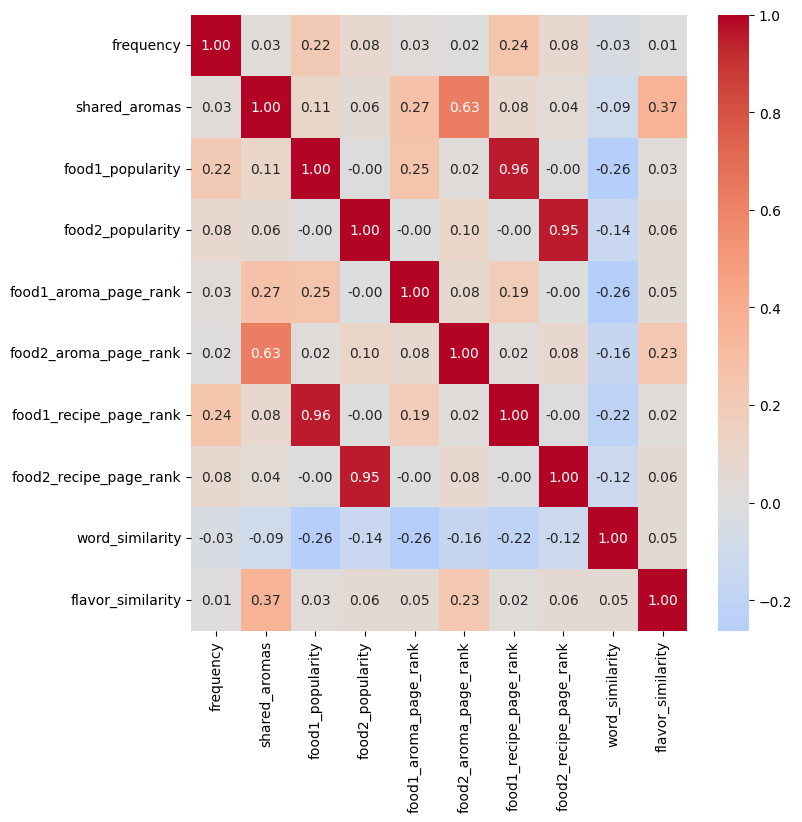

In [68]:
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, center=0, fmt=".2f", cmap="coolwarm")

In [82]:
# 下処理
# Split the data into features and target label
Xcolumns = target_column.copy()
Xcolumns.remove("frequency")

# Use MinMaxScaler to scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_X.fit_transform(df[Xcolumns])
y = scaler_y.fit_transform(df[["frequency"]]).flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric="rmse")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

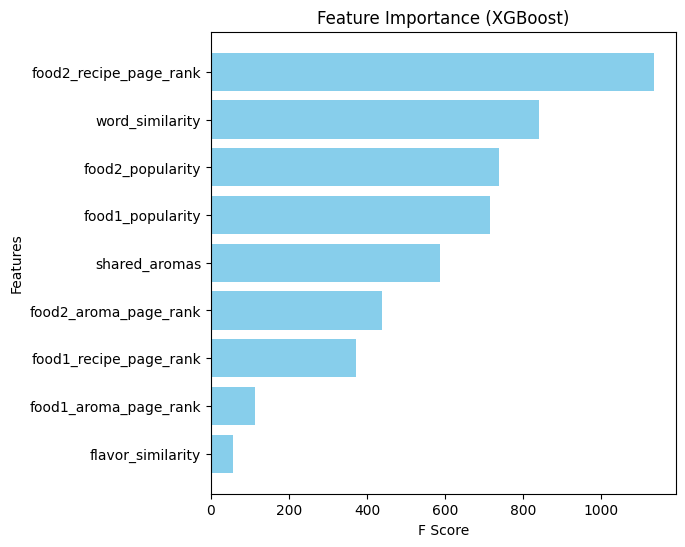

,Feature,Importance
6,food2_recipe_page_rank,1135.0
7,word_similarity,841.0
2,food2_popularity,739.0
1,food1_popularity,716.0
0,shared_aromas,588.0
4,food2_aroma_page_rank,438.0
5,food1_recipe_page_rank,372.0
3,food1_aroma_page_rank,113.0
8,flavor_similarity,56.0


In [83]:
def visualize_feature_importance(model, Xcolumns):
    """
    Visualize feature importance for a given XGBoost model.

    Parameters:
    - model: Trained XGBoost model.
    - Xcolumns: List of feature names.

    Returns:
    - importance_df: DataFrame containing feature importance.
    """
    feature_names = {f"f{i}": Xcolumns[i] for i in range(len(Xcolumns))}

    # Get importance and map feature names
    importance = model.get_booster().get_score(importance_type="weight")
    importance_named = {feature_names[k]: v for k, v in importance.items()}

    # Convert to DataFrame
    importance_df = pd.DataFrame(list(importance_named.items()), columns=["Feature", "Importance"])
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    # Visualization
    plt.figure(figsize=(6, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("F Score")
    plt.ylabel("Features")
    plt.title("Feature Importance (XGBoost)")
    plt.gca().invert_yaxis()  # Bring important features to the top
    plt.show()
    return importance_df

visualize_feature_importance(model, Xcolumns)

In [84]:
# Predict on test data
y_pred = model.predict(X_test)

# Evaluate accuracy
mse = mean_squared_error(y_test, y_pred)
print(f"Model MSE: {mse:.4f}")

# 新しいペアの予測
new_pair = pd.DataFrame([[5, 0, 0, 0, 0, 0, 0, 0, 0]], columns=Xcolumns)
new_pair_scaled = scaler_X.transform(new_pair)

predicted_frequency = model.predict(new_pair_scaled)[0]
threshold = 0.5  # **適切なしきい値を設定**
print("Unusual Pairing?", "Yes" if predicted_frequency < threshold else "No")

Model MSE: 0.0004
Unusual Pairing? Yes


In [192]:
# Apply log1p
df["frequency_log"] = np.log1p(df["frequency"])
# Define the threshold to 5 (arbitrary)
df["class"] = (df["frequency_log"] > 5).astype(int)
# Set class as the target(Y) column
y = df["class"]

# クラスの分布を確認 (SMOTE 前)
print("Before SMOTE:", Counter(y))

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE で少数派クラスを増やす
smote = SMOTE(sampling_strategy=0.5, k_neighbors=3, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# クラスの分布を確認 (SMOTE 後)
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 494959, 1: 397})
After SMOTE: Counter({0: 395966, 1: 197983})


In [193]:
# XGBoost の分類モデルを作成
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    scale_pos_weight=len(y_train_resampled) / (2 * sum(y_train_resampled == 1))
)

# モデルの学習
model.fit(X_train_resampled, y_train_resampled)

# 予測
y_pred = model.predict(X_test)

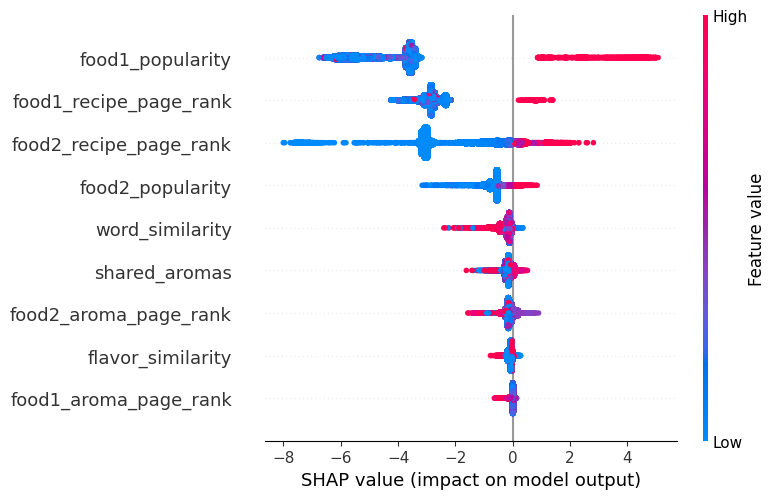

In [194]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=Xcolumns)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98993
           1       0.23      0.91      0.37        79

    accuracy                           1.00     99072
   macro avg       0.62      0.95      0.69     99072
weighted avg       1.00      1.00      1.00     99072



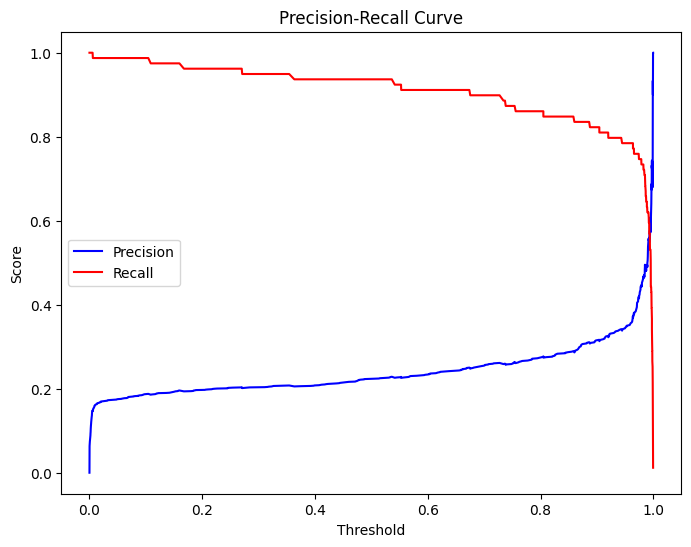

In [195]:
# 精度評価
y_pred_prob = model.predict_proba(X_test)[:, 1]

threshold = 0.6
y_pred_new = (y_pred_prob > threshold).astype(int)

# 精度評価
print(classification_report(y_test, y_pred_new))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [196]:
# 予測（リサンプル後のテストセットで評価）
y_pred_resampled = model.predict(X_train_resampled)

In [197]:
# Create Confusion Matrix
cm = confusion_matrix(y_train_resampled, y_pred_resampled)
cm

array([[394871,   1095],
       [     6, 197977]])

<Figure size 600x400 with 0 Axes>

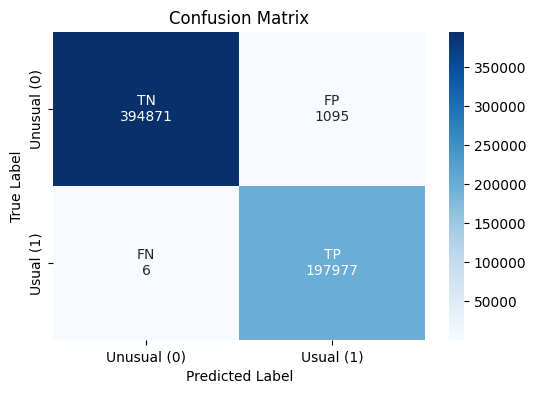

In [ ]:
# Create a heatmap
plt.figure(figsize=(6, 4))
# ラベルを文字列で埋め込んだアノテーション配列を作る
labels = ["Unusual (0)", "Usual (1)"]
annot_labels = np.array([
    [f'TN\n{cm[0,0]}', f'FP\n{cm[0,1]}'],
    [f'FN\n{cm[1,0]}', f'TP\n{cm[1,1]}']
])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=annot_labels, fmt='', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Evaluated on SMOTE Data)")
plt.show()

In [201]:
# Save model
with open("../data/unusual_paring_model.pkl", "wb") as file:
    pickle.dump(model, file)
    
model.save_model("../data/unusual_paring_model.json")

with open("../data/scaler_X.pkl", "wb") as file:
    pickle.dump(scaler_X, file)

with open("../data/scaler_y.pkl", "wb") as file:
    pickle.dump(scaler_y, file)
# Load model
with open("../data/unusual_paring_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)